In [1]:
'''
The following script performs a grid search on the normalized WDBC dataset to determine the optimal
amount of regularization for the neural network.  The grid search will assess pairs of two features
to determine the optimal degree of regularization: dropout percentage and maximum weight constraints.
Dropout percentage refers to the percentage of neurons in the hidden layers that are removed in each
training iteration.  Maximum weight limits puts a cap on the weighted connections between all of the neurons.
The optimal regularization is determine by the neural network with the maximum classifcation accuracy.
Dropout percentages between 0 and 90 percent in increments of 10 and max weights constraints between 1 and 5 in increments of 1
are tested.  Additionally, the grid seach will use the optimal neural network size determined in the
WDBC_norm_GS_Layer_Size script (Layer 1: 30 neurons, Layer 2: 40 neurons).
The script using Keras deep learning software framework to build and update the network.
An Amazon GPU (instance type: g2.2xlarge) was used to reduce network training times.
'''

# Load required classes and functions from Keras and Numpy
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l2, activity_l2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm

Using TensorFlow backend.


In [5]:
# Fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Load the min-max normalized Wisconsin Diagnostic Breast Cancer Dataset
dataset = numpy.loadtxt("WDBC_norm.csv", delimiter=",")

# Create input features and output classification data
X = dataset[:,0:30]
Y = dataset[:,30]

In [3]:
# Below function builds the neural network structure with the appropriate regularization
def create_baseline(dropout_rate=0.0, weight_constraint=0):
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim=30, init='normal', activation='relu', W_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, init='normal', activation='relu', W_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, init='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
# Build neural network with required parameters
model = KerasClassifier(build_fn=create_baseline, nb_epoch=500, batch_size=100, verbose=2)

In [8]:
# Perform grid search to determine optimal degree of regularization
weight_constraint = [1, 2, 3]
dropout_rate = [0.6, 0.7, 0.8]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator = model,param_grid = param_grid, cv=kfold)
grid_result = grid.fit(X,Y)

Epoch 1/500
0s - loss: 0.6927 - acc: 0.6300
Epoch 2/500
0s - loss: 0.6918 - acc: 0.6960
Epoch 3/500
0s - loss: 0.6905 - acc: 0.6960
Epoch 4/500
0s - loss: 0.6896 - acc: 0.6762
Epoch 5/500
0s - loss: 0.6880 - acc: 0.7203
Epoch 6/500
0s - loss: 0.6855 - acc: 0.7048
Epoch 7/500
0s - loss: 0.6855 - acc: 0.6872
Epoch 8/500
0s - loss: 0.6819 - acc: 0.7026
Epoch 9/500
0s - loss: 0.6775 - acc: 0.7423
Epoch 10/500
0s - loss: 0.6721 - acc: 0.7687
Epoch 11/500
0s - loss: 0.6656 - acc: 0.7775
Epoch 12/500
0s - loss: 0.6615 - acc: 0.7797
Epoch 13/500
0s - loss: 0.6537 - acc: 0.7797
Epoch 14/500
0s - loss: 0.6409 - acc: 0.8106
Epoch 15/500
0s - loss: 0.6261 - acc: 0.8150
Epoch 16/500
0s - loss: 0.6160 - acc: 0.7974
Epoch 17/500
0s - loss: 0.6035 - acc: 0.8040
Epoch 18/500
0s - loss: 0.5886 - acc: 0.8106
Epoch 19/500
0s - loss: 0.5747 - acc: 0.8150
Epoch 20/500
0s - loss: 0.5430 - acc: 0.8370
Epoch 21/500
0s - loss: 0.5315 - acc: 0.8194
Epoch 22/500
0s - loss: 0.5096 - acc: 0.8326
Epoch 23/500
0s - l

In [21]:
# Determine opitmal regularization and print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.975395 using {'dropout_rate': 0.6, 'weight_constraint': 1}
0.975395 (0.010321) with: {'dropout_rate': 0.6, 'weight_constraint': 1}
0.970123 (0.010510) with: {'dropout_rate': 0.6, 'weight_constraint': 2}
0.968366 (0.008875) with: {'dropout_rate': 0.6, 'weight_constraint': 3}
0.973638 (0.012527) with: {'dropout_rate': 0.7, 'weight_constraint': 1}
0.968366 (0.013118) with: {'dropout_rate': 0.7, 'weight_constraint': 2}
0.975395 (0.010321) with: {'dropout_rate': 0.7, 'weight_constraint': 3}
0.973638 (0.015862) with: {'dropout_rate': 0.8, 'weight_constraint': 1}
0.973638 (0.011133) with: {'dropout_rate': 0.8, 'weight_constraint': 2}
0.973638 (0.011133) with: {'dropout_rate': 0.8, 'weight_constraint': 3}


In [82]:
# output results to results.txt
wrt = open("results.txt", 'w')
wrt.write('weight_constraint' + ',' + 'dropout_rate' + ',' + 'mean\n')
for i in range(len(params)):
    wrt.write(str(params[i]['weight_constraint'])+','+str(params[i]['dropout_rate'])+','+str(means[i])+'\n')
wrt.close()

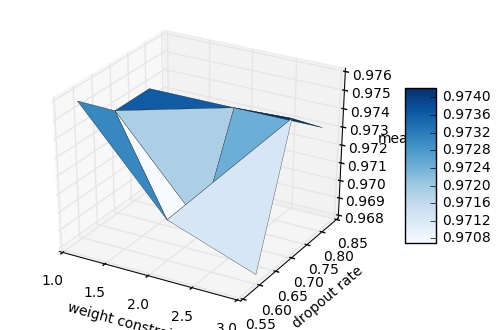

In [91]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x = []
y = []
z = []

# read in values from results.txt and store in arrays x,y,z
for l in open("results.txt"):
    if l.startswith("weight_constraint"):
        continue  
    weight_constraint, drop_out, mean = l.strip().split(',')
    x.append(float(weight_constraint))
    y.append(float(drop_out))
    z.append(float(mean))

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='Blues', linewidth=0.2)
ax.set_xlabel('weight constraint')
ax.set_ylabel('dropout rate')
ax.set_zlabel('mean')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()